In [19]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [20]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide'] < 200]  # drop a few outliers

# z-score all columns
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,-0.786623
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,-0.786623
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,0.453492
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217380,0.401792,-0.980138,-0.380922,0.052836,1.547828,-0.068233,-0.982759,0.899027,-0.462207,0.074599,-0.786623
1595,-1.389638,0.122359,-0.877216,-0.237608,-0.542132,2.218623,0.151778,-0.865964,1.353377,0.599872,0.732539,0.453492
1596,-1.159961,-0.101187,-0.722834,-0.165951,-0.244648,1.260344,-0.193954,-0.536815,0.704305,0.540868,0.544556,0.453492
1597,-1.389638,0.653281,-0.774295,-0.380922,-0.265897,1.547828,-0.068233,-0.680154,1.677912,0.304850,-0.207376,-0.786623


# Re-organize the data: train/test in DataLoaders

In [21]:
cols2zscore = cols2zscore.drop("residual sugar")

# convert from pandas dataframe to tensor
dataT  = torch.tensor(data[cols2zscore].values).float()
# labels = torch.tensor( data['boolQuality'].values ).float()
labels = torch.tensor(data['residual sugar'].values).float()
labels = labels[:, None]  # transform to matrix
labels

tensor([[-0.4526],
        [ 0.0490],
        [-0.1660],
        ...,
        [-0.1660],
        [-0.3809],
        [ 0.7656]])

In [22]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# Now for the DL part

In [23]:
# create a class for the model
class ANNwine(nn.Module):

    def __init__(self):
        super().__init__()

        ### input layer
        self.input = nn.Linear(11, 16)

        ### hidden layers
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)

        ### output layer
        self.output = nn.Linear(32, 1)

    # forward pass
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))  # fully connected
        x = F.relu(self.fc2(x))
        return self.output(x)

# Train the model

In [24]:
# a function that trains the model

# global parameter
num_epochs = 1000


def trainTheModel(winenet, train_loader, test_loader):
    # loss function and optimizer
    lossfun = nn.MSELoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)

    # initialize losses
    train_losses = torch.zeros(num_epochs)
    test_losses = torch.zeros(num_epochs)
    train_accuracy = []
    test_accuracy = []

    # loop over epochs
    for epochi in range(num_epochs):
        # switch on training mode
        winenet.train()

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            # batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
            # if we wanted to compute the accuracy, we could run a correlation between
            # yHat and y and visualise that over training
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        train_accuracy.append(np.mean(batchAcc))

        # and get average losses across the batches
        train_losses[epochi] = np.mean(batchLoss)

        # test accuracy
        winenet.eval()
        X, y = next(iter(test_loader))  # extract X,y from test dataloader
        with torch.no_grad():  # deactivates autograd
            yHat = winenet(X)
        test_losses[epochi] = lossfun(yHat, y).item()
        # test_accuracy.append(100 * torch.mean(((yHat > 0) == y).float()).item())

    # function output
    return train_accuracy, test_accuracy, train_losses, test_losses

# Now for the experiment

In [26]:
# create dataloader object
train_loader = DataLoader(train_dataDataset, batch_size=32, shuffle=True, drop_last=True)
# test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# create and train a model
winenet = ANNwine()
train_accuracy, test_accuracy, train_losses, test_losses = trainTheModel(winenet, train_loader, test_loader)

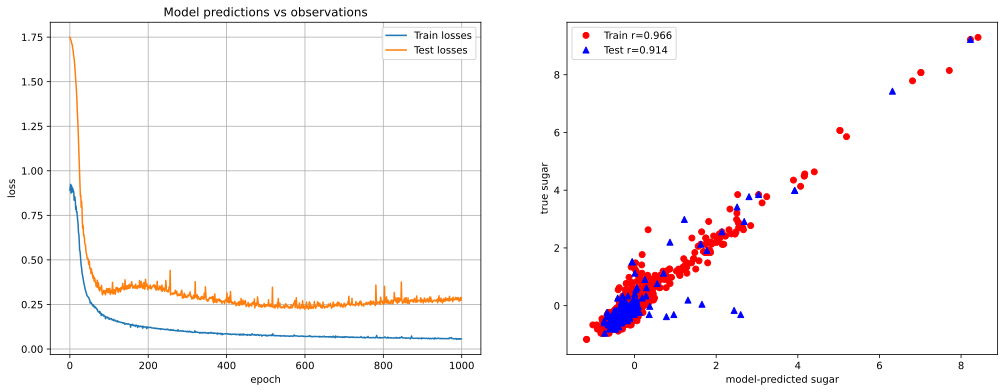

In [27]:
# plot some results
fig, ax = plt.subplots(1, 2, figsize=(17, 6))

ax[0].plot(train_losses, label="Train losses")
ax[0].plot(test_losses, label="Test losses")
ax[0].set_title("Train and test losses")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[0].grid()

y_hat_train = winenet(train_data)
y_hat_test = winenet(test_data)
ax[1].plot(y_hat_train.detach(), train_labels, "ro")
ax[1].plot(y_hat_test.detach(), test_labels, "b^")
ax[0].set_title("Model predictions vs observations")
ax[1].set_xlabel("model-predicted sugar")
ax[1].set_ylabel("true sugar")

correlation_train = np.corrcoef(y_hat_train.detach().T, train_labels.T)[1, 0]
correlation_test = np.corrcoef(y_hat_test.detach().T, test_labels.T)[1, 0]
ax[1].legend(
    [f"Train r={correlation_train:.3f}", f"Test r={correlation_test:.3f}"])

plt.show()

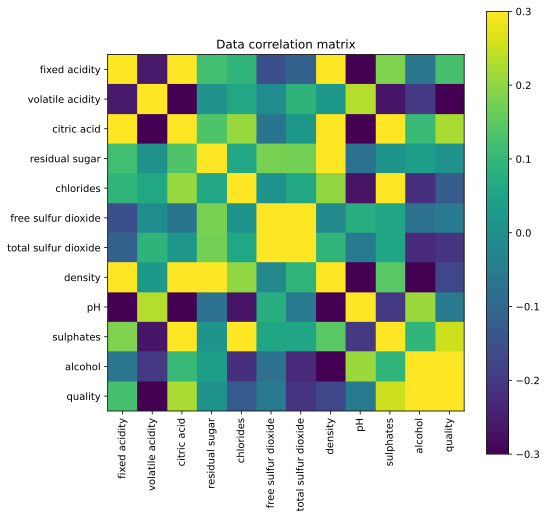

In [29]:
# Inspect the correlation matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()

# Additional explorations

In [28]:
# 1) There is another regularization technique called "early stopping," which simply means to stop training the model
#    earlier than the number of epochs you specified. Early stopping is used when the test accuracy starts to decrease
#    with increased training. Do you think that early stopping would be beneficial here? How many epochs would you train?
# 
# 2) The training loop computes the losses, but those aren't plotted. Create an additional subplot to show the losses
#    in a similar fashion as the accuracy. Does that plot provide any additional insights into the effects of minibatch
#    size, beyond what we can already learn from the accuracy plots.
# 